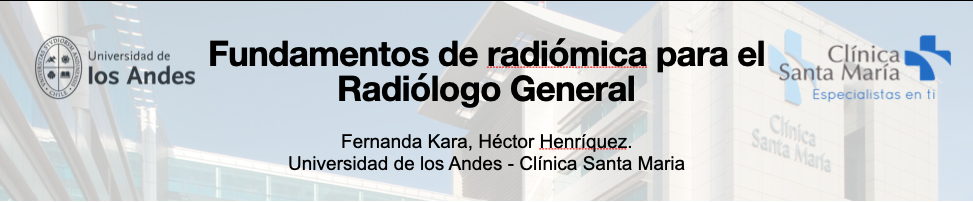

In [ ]:
## Instalación de algunas librerias
!pip install dataframe-image
!pip install pynrrd

In [23]:
## Carga de librerias necesarias

import cv2
import numpy as np
import pandas as pd
import dataframe_image as dfi
import matplotlib.pyplot as plt
from plotnine import*
import nrrd
#import openml
from skimage.filters.rank import entropy
from skimage.feature import greycomatrix, greycoprops
from skimage.morphology import disk
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [3]:
def show_slice_window(slice, level, window):
    
    """
    input: imagen array 2D, 
    permite ajustar ventana y nivel para mejorar contraste de la imagen.
    output: imagen array 2D ventaneada.
   """
    
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)

def compute_entropy(im):
    """
    Input: Recibe imagen como array 2D.
    Genera histograma normalizado.
    Calcula la entropía: e = -sum(p(g)*log2(p(g)))
    Output: Entropía
    """ 
    p = np.array([(im==v).sum() for v in range(256)])
    p = p/p.sum()
    e = -(p[p>0]*np.log2(p[p>0])).sum()
    
    return (e)

## Acceso al set de imágenes:
https://drive.google.com/file/d/1TbnYieLiQ_WymTexSpFeZ0jqRZpMy20M/view?usp=sharing

In [4]:
### carga de imágenes
all_images = np.load('/content/tensor con imagenes de ejemplo.npy', allow_pickle=True)
print("dimensiones:", all_images.shape)
print("\nEtiquetas:\n1. {}, 2. {}, \n3.{}, 4.{}, \n5.{}".format(all_images[0][2], all_images[1][2], 
                                                   all_images[2][2], all_images[3][2], 
                                                   all_images[4][1]))


dimensiones: (5,)

Etiquetas:
1. clear cell, 2. papilar rcc, 
3.efgr mutant, 4.egfr wild type, 
5.lung nodule 8 bit (no mask)


## Fundamentos de radiómica para el radiólogo general

* Autores: Héctor Henríquez, Fernanda Kara
* E-mail de contacto: hhenriquez@miuandes.cl
* Universidad de los Andes, Chile.

### Introducción:

La radiómica se define como el análisis cuantitativo de imágenes médicas y permite extraer características desde las imágenes, algunas invisibles al ojo humano. Estas características se pueden correlacionar con un comportamiento biológico de interés como histología, expresión genética y respuesta a tratamientos, entre otras. 
Actualmemte corresponde a un campo de investigación emergente, lo que se ha visto reflejado en un aumento importante de publicaciones en los últimos años. 

Objetivos: Los objetivos de este trabajo son revisar los fundamentos básicos de las características radiómicas y sus aplicaciones en radiología.


Primeros pasos:
En primer lugar debemos comprender qué es una imagen y sus principales propiedades matemáticas.

Una imagen digital es una matriz de números enteros, que corresponde a la representación bidimensional de la realidad. Su unidad básica es el pixel (picture element) y tiene diferentes dimensiones: alto, ancho y canales de color. 
Existen imágenes de tipo volumétrico como las imágenes axiales radiológicas (CT, MRI o PET-CT) que además tienen una cuarta dimensión, la que corresponde al espesor de corte. Este pixel volumétrico es lo que se conoce como voxel.

dimensiones imagen: (2462, 2462, 3)


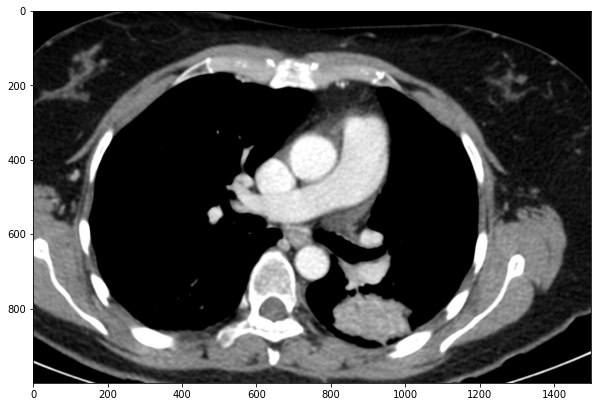

In [5]:
## Carga de imagen de Nódulo Pulmonar neoplásico en 8 bit

print("dimensiones imagen:", (all_images[4][0]).shape)
## Se ajusta el FOV
lungNoduleROI = all_images[4][0][1000:2000, 500:2000]

plt.figure(figsize=(10,10))
plt.imshow(lungNoduleROI, cmap='gray')

### Características de las imágenes
El valor que toma cada pixel depende de la profundidad de bits. A mayor profundidad de bits se pueden almacenar una mayor cantidad de valores.
Las imágenes convencionales se codifican
en 8 bits, tomando valores que van desde el 0 (negro) al 255 (blanco).
Sin embargo, las imágenes radiológicas deben capturar mayor información en la escala de grises y por eso se codifican en 16 bits.
En los histogramas de más abajo podemos ver la diferencia de los valores:
Histograma I: imagen en 8 bit.
Histograma II: imagen de tomografía computada en 16 bits.

In [6]:
## Visualización de valores de los pixeles

## redimensionado de la imagen para crear tabla de datos
## con los valores de pixeles.
dim = 40,40

noduleResize = cv2.resize(lungNoduleROI[:,:,0], dim,
               interpolation = cv2.INTER_NEAREST)

## Creación de tabla de datos
df = pd.DataFrame(noduleResize)

df_styled = df.style.background_gradient()
df_styled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,0,0,0,0,0,16,39,8,9,1,32,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,59,20,8,12,11,13,20,11,4,0,18,8,44,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,44,9,5,19,12,16,11,20,41,9,11,7,3,5,2,10,28,14,19,1,0,0,0,0,0,0,0,5,14,56,0,0,0,0,0,0,0
3,0,0,13,11,8,21,14,41,18,13,32,20,19,43,33,32,27,37,34,19,23,31,23,29,9,15,8,18,22,33,21,4,6,7,31,0,0,0,0,0
4,0,6,18,11,36,27,17,12,15,25,21,25,28,135,139,147,122,81,39,33,36,36,34,33,26,21,21,30,8,10,15,6,7,15,7,21,45,0,0,0
5,8,18,11,95,85,20,20,18,5,27,14,65,142,160,163,157,139,143,111,77,151,142,137,131,126,23,12,25,18,11,15,20,15,18,56,6,16,22,0,0
6,25,12,7,27,114,52,14,9,22,16,118,76,115,181,183,192,183,188,255,228,254,152,159,178,160,139,68,21,19,17,15,15,16,41,21,9,7,7,25,0
7,25,10,15,89,63,14,12,21,24,107,119,182,1,0,1,111,170,167,255,233,202,187,166,171,168,255,114,108,22,6,12,17,12,31,95,91,9,19,7,47
8,16,17,20,83,18,8,23,25,126,134,121,0,0,0,0,0,0,160,255,222,255,145,146,48,37,136,168,28,124,26,20,17,1,40,69,32,20,42,28,6
9,21,102,74,92,63,10,24,114,136,124,0,0,0,0,0,0,0,0,0,0,0,41,29,35,41,0,0,65,141,139,17,15,12,21,91,71,9,44,14,9


### Visualización de los histogramas

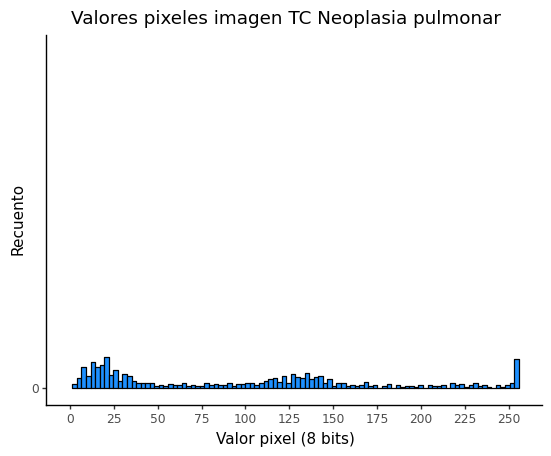

In [7]:
graficoPixeles8bits = (
ggplot()+
    aes(x=noduleResize.flatten())+
    geom_histogram(fill='dodgerblue', color='black', bins=100)+
    theme_classic()+
    labs(title='Valores pixeles imagen TC Neoplasia pulmonar', x='Valor pixel (8 bits)', y='Recuento') +
    scale_x_continuous(limits=[-1,256], breaks=list(range(0,256,25))) +
    scale_y_continuous(breaks=list(range(0,1750000,250000)))
    
)

print(graficoPixeles8bits)

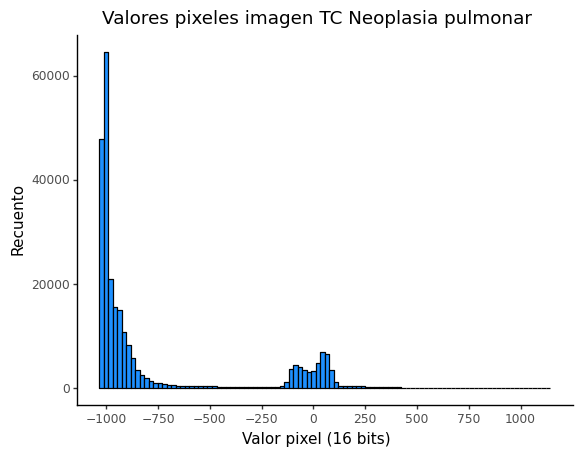

In [8]:
graficoPixeles16Bit = (
ggplot()+
    aes(x=all_images[3][0].flatten())+
    geom_histogram(fill='dodgerblue', color='black', bins=100)+
    theme_classic()+
    labs(title='Valores pixeles imagen TC Neoplasia pulmonar', x='Valor pixel (16 bits)', y='Recuento') +
    scale_x_continuous(breaks=list(range(-1000,1001, 250)))
    
)
print(graficoPixeles16Bit)

Estas propiedades nos permiten realizar análisis cuantitativo de las imágenes. Para esto necesitamos definir un área de interés (ROI), que será el área de la imagen desde la que extraeremos los pixeles necesarios.

En el siguiente ejemplo podemos ver un tumor renal izquierdo segmentado (imagen A). La segmentación define los pixeles relevantes, que son los que posteriormente extraemos (imágenes B y C).
Luego podemos realizar un análisis estadístico de los pixeles.


## Visualización de ROI de RCC extraido

label: clear cell


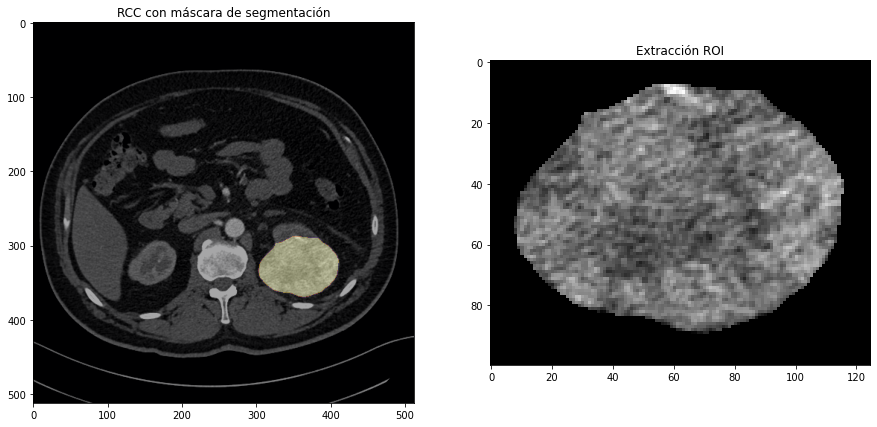

In [9]:
print("label:", all_images[0][2])

## Configuración de la ventana:
level = 100
window_width = 500
alpha = 0.35

## Configuración de la ventana:
level_roi = 120
window_width_roi = 400

roi_rcc = np.where(all_images[0][1] == 1, all_images[0][0], -1000)
rcc_extracted = roi_rcc[280:380, 295:420]
rcc_mask = all_images[0][1][280:380, 295:420]


f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.title("RCC con máscara de segmentación")
plt.imshow(show_slice_window(all_images[0][0], level, window_width), cmap='gray')
plt.imshow(all_images[0][1], cmap='inferno', alpha= alpha)

f.add_subplot(1, 2, 2)
plt.title("Extracción ROI")
plt.imshow(show_slice_window(rcc_extracted,level_roi , window_width_roi), cmap='gray')
plt.show()



In [10]:
## Redimensionado y creación de tabla con valores de pixeles
dim = 37, 35

rccRes = cv2.resize(rcc_extracted, dim,
               interpolation = cv2.INTER_NEAREST)
rccRes2 = np.where(rccRes == -1000, 0, rccRes)

df_rcc = pd.DataFrame(rccRes2)

df_styled_RCC = df_rcc.style.background_gradient()
df_styled_RCC
# dfi.export(df_styled_RCC, 'RCC_DF.png', max_cols=-1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82,210,186,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,45,82,99,109,170,83,98,17,25,104,34,48,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,49,102,78,60,44,25,112,121,98,96,67,12,65,65,10,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,41,119,46,72,106,68,32,108,78,96,87,85,27,40,50,70,38,38,32,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,-4,64,103,121,121,92,108,114,81,80,50,0,-12,70,24,-19,73,68,95,112,30,51,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,62,67,98,48,36,96,98,146,69,65,60,48,19,9,2,113,126,108,39,55,63,67,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,2,98,98,63,83,116,66,113,79,87,78,56,46,-23,32,86,89,69,82,119,153,117,58,95,0,0,0,0,0


## Tipos de características radiómicas:

### Basadas en la morfología (semánticas):
* Diámetro, área, superficie, coeficientes de esfericidad, etc

### Basadas en Intensidad de los pixeles: 
* También conocidas como basadas en histograma o de primer orden:
* Media, desviación estándar, percentiles, minimo, máxmo, kurtosis, skewnes, entre
otras.

### Basadas en textura: 
* También conocidas como de segundo orden. Representan la complejidad de la distribución espacial de los pixeles y sus relaciones.
* Existen varios grupos, los mas conocidos son co-ocurrence matrix (GLCM), run length matrix (GLRLM), gray-level size_zone matriz (GLSZM), entre otros.

## Características de textura

Las dos imágenes binarias (a y b), tienen igual cantidad de pixeles negros, por lo tanto tendrán métricas basadas en histograma que serán idénticas (promedio, desviación estándar, mínimo, máximo, etc).
Sin embargo, podemos ver que la distribución espacial de los pixeles es diferente, siendo una diagonal perfecta en la imagen b.
Esta especialidad la pueden capturar las métricas de textura, como la co-ocurrencia de valores grises (GLCM).
Esto ha mostrado buena correlación con la estructura tisular de los tumores.

In [11]:
## Cálculo de entropia

from skimage.filters.rank import entropy
from skimage.feature import greycomatrix, greycoprops

def compute_entropy(im):
    # Compute normalized histogram -> p(g)
    p = np.array([(im==v).sum() for v in range(256)])
    p = p/p.sum()
    # Compute e = -sum(p(g)*log2(p(g)))
    e = -(p[p>0]*np.log2(p[p>0])).sum()
    
    return e

entropia: 0.7219280948873623
Media: 50.8
GLCM dissimilarity: 101.60000000000001
GLCM correlation: -0.25


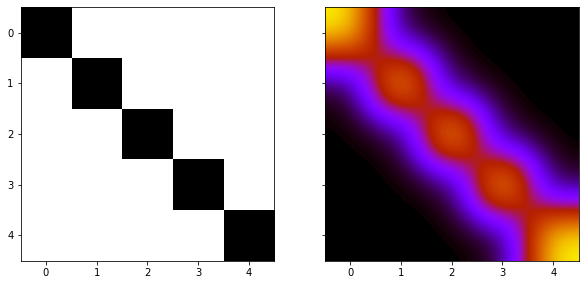

In [12]:
arrayUno = np.array([[ 1, 0, 0,0, 0],
                    [ 0, 1, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                    [0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 1]], dtype='uint8')

arrayUno = arrayUno * 254

print("entropia:", compute_entropy(arrayUno))
print("Media:", arrayUno.mean())

glcm = greycomatrix(arrayUno, distances=[2], angles=[0], levels=255,
                        symmetric=True, normed=True)

print("GLCM dissimilarity:", greycoprops(glcm, 'dissimilarity')[0, 0])
print("GLCM correlation:", greycoprops(glcm, 'correlation')[0, 0])


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))

ax1.imshow(arrayUno, cmap='gray_r')

ax2.imshow(arrayUno, cmap='gnuplot', interpolation='gaussian')
plt.savefig('arrayUno.png', dpi=300)

entropia: 0.7219280948873623
Media: 50.8
GLCM dissimilarity: 84.66666666666666
GLCM correlation: 0.06832298136645959


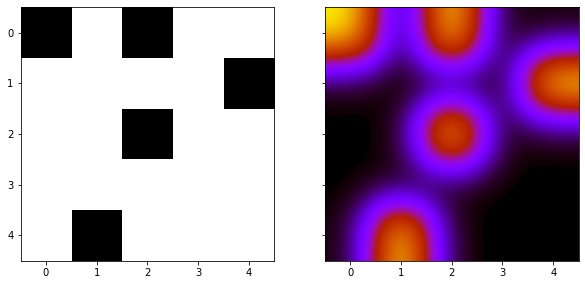

In [13]:
arrayDos = np.array([[ 1, 0, 1, 0, 0],
                    [ 0, 0, 0, 0, 1],
                    [0, 0, 1, 0 , 0],
                    [0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0]], dtype='uint8')

arrayDos = arrayDos*254

print("entropia:", compute_entropy(arrayDos))
print("Media:", arrayDos.mean())
glcm = greycomatrix(arrayDos, distances=[2], angles=[0], levels=255,
                        symmetric=True, normed=True)

print("GLCM dissimilarity:", greycoprops(glcm, 'dissimilarity')[0, 0])
print("GLCM correlation:", greycoprops(glcm, 'correlation')[0, 0])


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))

ax1.imshow(arrayDos, cmap='gray_r')
ax2.imshow(arrayDos, cmap='gnuplot', interpolation='gaussian')
plt.savefig('arrayDos.png', dpi=600)

## Ejemplo Cáncer de pulmón: EGFR mutado versus no mutado

Etiqueta: efgr mutant


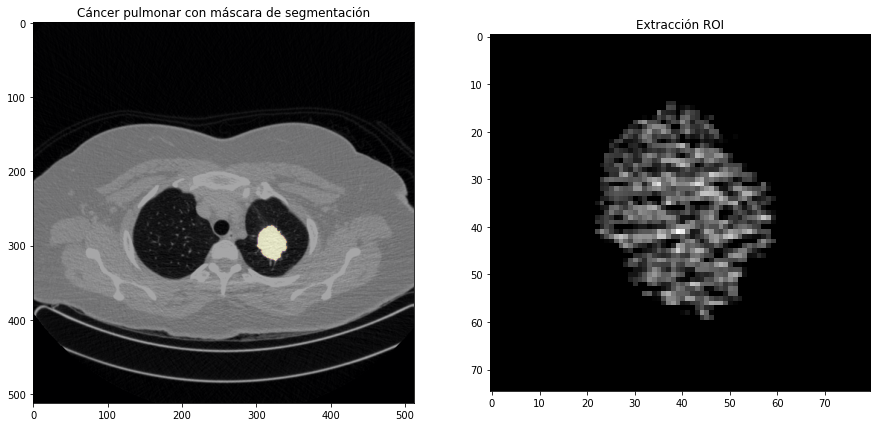

In [15]:
## Tumores pulmonares egfr positivo - negativo

level = -600
window_width = 1800

print("Etiqueta:",all_images[2][2])

## Se realiza extracción del ROI

egfr_extracted = np.where(all_images[2][1] == 1, all_images[2][0], 0)
egfr_extracted = np.where(egfr_extracted < 0, 0, egfr_extracted)
egfr_roi = egfr_extracted[260:335,280:360]


f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.title("Cáncer pulmonar con máscara de segmentación")
plt.imshow(show_slice_window(all_images[2][0], level, window_width), cmap='gray')
plt.imshow(all_images[2][1], cmap='inferno', alpha= alpha)

f.add_subplot(1, 2, 2)
plt.title("Extracción ROI")
plt.imshow(show_slice_window(egfr_roi, level, window_width), cmap='gray')
plt.show()


GLCM dissimilarity: 8.97367521367521
GLCM correlation: 0.7416774417862627


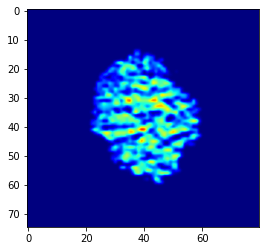

In [16]:
glcm = greycomatrix(egfr_roi, distances=[2], angles=[0], levels=237,
                        symmetric=True, normed=True)

print("GLCM dissimilarity:", greycoprops(glcm, 'dissimilarity')[0, 0])
print("GLCM correlation:", greycoprops(glcm, 'correlation')[0, 0])


plt.figure()
plt.imshow(egfr_roi, cmap='jet', interpolation='gaussian')
plt.show()
#plt.savefig('roi_egfr positivo 2.png', dpi=900)

Etiqueta: egfr wild type


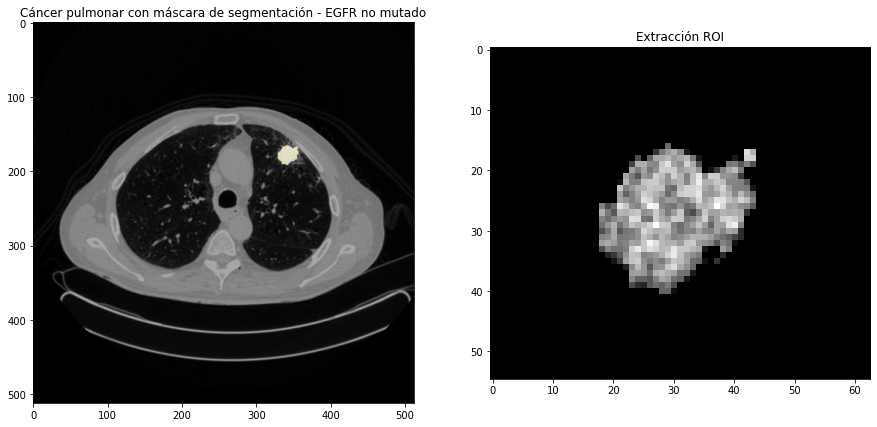

In [17]:
### EGFR no mutado
level = -600
window_width = 1800
alpha = 0.35

print("Etiqueta:",all_images[3][2])

## ROI
egfr_wild_extracted = np.where(all_images[3][1] == 1, all_images[3][0], 0)
egfr_wild_extracted = np.where(egfr_wild_extracted < 0, 0, egfr_wild_extracted)
egfr_wild_ROI = egfr_wild_extracted[150:205, 312:375]


f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.title("Cáncer pulmonar con máscara de segmentación - EGFR no mutado")
plt.imshow(show_slice_window(all_images[3][0], level, window_width), cmap='gray')
plt.imshow(all_images[3][1], cmap='inferno', alpha=alpha)

f.add_subplot(1, 2, 2)
plt.title("Extracción ROI")
plt.imshow(show_slice_window(egfr_wild_ROI, level, window_width), cmap='gray')
plt.show()

GLCM dissimilarity: 3.5093889716840505
GLCM correlation: 0.8344568236210795


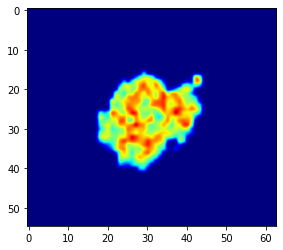

In [18]:
egfr_wild_roi = egfr_wild_extracted[150:205, 312:375]

glcm = greycomatrix(egfr_wild_roi, distances=[2], angles=[0], levels=egfr_wild_roi.max() + 1,
                        symmetric=True, normed=True)

print("GLCM dissimilarity:", greycoprops(glcm, 'dissimilarity')[0, 0])
print("GLCM correlation:", greycoprops(glcm, 'correlation')[0, 0])


plt.figure()
plt.imshow(egfr_wild_roi, cmap='jet', interpolation='gaussian')
#plt.savefig('tumor egfr negativo roi 2.png', dpi=900)
plt.show()

### Preprocesamiento

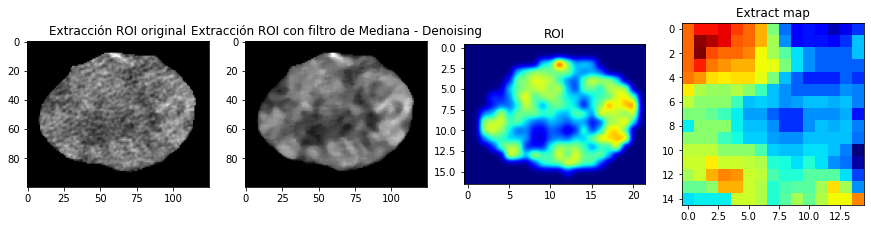

In [19]:
## Reducción de Ruido
rcc_blur = cv2.medianBlur(rcc_extracted, 5)

dim= 22,17

rcc_blur_resize = cv2.resize(show_slice_window(rcc_blur,250 , 500), dim,
               interpolation = cv2.INTER_NEAREST)


f = plt.figure(figsize=(15,15))

f.add_subplot(1, 4, 1)

plt.title("Extracción ROI original")
plt.imshow(show_slice_window(rcc_extracted,level_roi , window_width_roi), cmap='gray')

f.add_subplot(1, 4, 2)
plt.title("Extracción ROI con filtro de Mediana - Denoising")
plt.imshow(show_slice_window(rcc_blur,230 , 500), cmap='gray')

f.add_subplot(1, 4, 3)
plt.title("ROI")
plt.imshow(rcc_blur_resize,  cmap='jet', interpolation='gaussian')

f.add_subplot(1, 4, 4)
plt.title("Extract map")
plt.imshow(rcc_blur[30:45,60:75], cmap='jet')
plt.show()


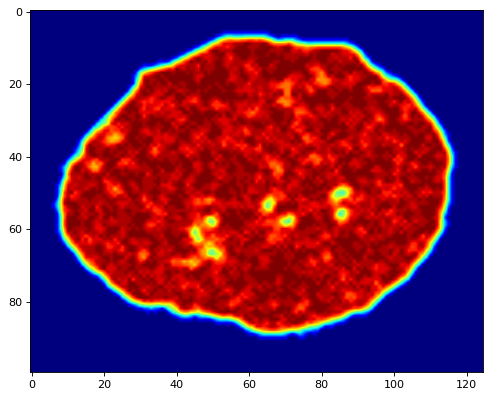

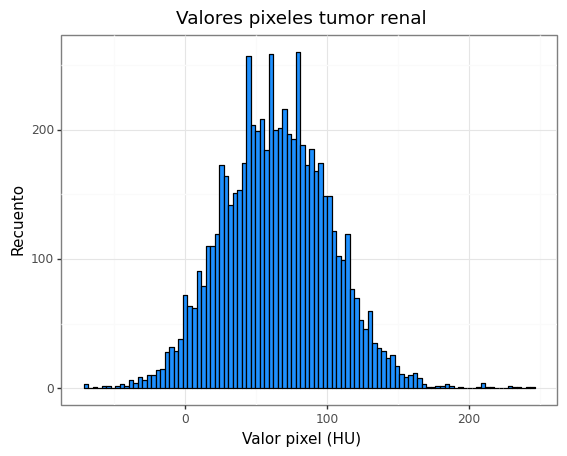

In [26]:
## Valores sólo del tumor

valores_tumor = []

for i in range(rcc_extracted.flatten().shape[0]):
    if(rcc_mask.flatten()[i] ==1):
        valores_tumor.append(rcc_extracted.flatten()[i])
    
valores_tumor = np.array(valores_tumor)

entropy_image = entropy(rcc_extracted, disk(2))

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(entropy_image, cmap = 'jet', interpolation='bilinear')
plt.show()

graficoPixeles = (
ggplot()+
    aes(x=valores_tumor)+
    geom_histogram(fill='dodgerblue', color='black', bins=100)+
    theme_bw()+
    labs(title='Valores pixeles tumor renal', x='Valor pixel (HU)', y='Recuento') 
    #scale_y_continuous(limits=[0,800])
    
)

print(graficoPixeles)

### Descripción del flujo
El objetivo es extraer en forma sistemática las diferentes características, disminuyendo la variabilidad existente entre las imágenes para obtener el mejor rendimiento diagnóstico.
La segmentación puede ser manual, semiautomática o automática. Actualmente existen algunos frameworks que permiten realizar segmentación automática con Deep Learning para imágenes médicas con una significativa reducción en el tiempo (por. Ej. MONAI Label).
El preprocesamiento de las imágenes busca reducir la variabilidad. Los pasos habituales son:
Resampling: Dejar todos los voxels de igual tamaño.
Normalización o estandarización: Corresponde al re-escalado de los valores de intensidad de los pixeles (-1000 a 1000 en el caso de la TC). Se dejan entre 0 y 1 en el caso de la normalización o con media 0 y desviación estándar de 1 en el caso de la estandarización.
La discretización corresponde a la agrupación de los valores en un intervalo definido, y permite reducir la variabilidad.
Finalmente la extracción de características se puede realizar con diferentes software o librerías opensource como pyradiomics [ref].

### Dificultades:
Número de pacientes.
Variabilidad de las imágenes por diferencias de equipos y protocolos.
Diferencias en el preprocesamiento que pueden determinar variaciones en los resultados.
Alta dimensionalidad del problema. Habitualmente se extraen cientos o incluso miles de características desde cada paciente, lo que genera una dificultad en el modelamiento estadístico.
Variables altamente correlacionadas. Debido a la utilización de filtros, algunas métricas son evaluadas varias veces con filtros, las que estarán fuertemente correlacionadas entre ellas. Esto genera una gran multicolinealidad en los datos, que dificulta el modelamiento.